# This entire script gives a detailed code walk-through on how to extract interesting insights from your own WhatsApp chat data.

Install demoji and emoji packages.
The below code shows packages installation on Google Colab, if using any other notebook or editor then follow the respective package installation process.

In [202]:
!pip install demoji
!pip install emoji
!pip install plotly>=4.7.1
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

/usr/local/bin/orca: Text file busy
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgtk2.0-0 is already the newest version (2.24.32-1ubuntu1).
libgconf-2-4 is already the newest version (3.2.6-4ubuntu1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.4).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 43 not upgraded.


###The following process is on how to extract WhatsApp chat data

1.   Select your Chat. 
2.   Select "More" in the dropdown menu of your desired chat.
3.   Select "Export chat".
4.   Select "Without media".
5.   Select any of the methods to export the chat, either through Gmail or Google Drive.   



The chat file after exporting is in txt format.

In [203]:
raw_data = open("WhatsApp Chat with x.txt")

###Create a csv file, which will later be used as a pandas dataframe.

In [204]:
import csv
with open('chat.csv', mode='w') as csv_file:
  csvwriter = csv.writer(csv_file)
  csvwriter.writerow(['Date', 'Time', 'Name', 'Message'])

The below code creates a "chat.csv" file which cleans the raw_data.

Regular expressions are used to validate the date and time of a text from raw_data.
Two regular expressions are used as there are two types of date and time formats is different chats. (could be more, feel free to explore)

String slicing is then used to seperate Date, Time, Name and Message sections and add them to the "chat.csv" file.

In [205]:
import regex
line_num = 0

for line in raw_data:
  line_num += 1
  if regex.match('[0-9]+/[0-9]+/[0-9]+, [0-9]+:[0-9]+ [AP]M - .*: .*', line) is not None \
    or regex.match('[0-9]+/[0-9]+/[0-9]+, [0-9]+:[0-9]+ - .*: .*', line) is not None:
    sep = line.find('-')
    timestamp = line[0:sep]
    timestamp = timestamp.split(', ')
    name_sep = line.find(':', sep) #asuming the name doesn't have ':'
    name = line[sep+2:name_sep]
    message = line[name_sep+1:]
    with open('chat.csv', mode='a+', newline='') as csv_file:
      csvwriter = csv.writer(csv_file)
      csvwriter.writerow([timestamp[0], timestamp[1], name, message])

###Covert the "chat.csv" to pandas dataframe.

In [206]:
import pandas as pd
wa_data = pd.read_csv('chat.csv')

(Optional)
I have used the following piece of code to mask the actual names with dummy names.

In [207]:
new_names = []
for i in range(len(wa_data.Name.unique())):
  new_names.append('Member'+str(i+1))
wa_data.replace(list(wa_data.Name.unique()), new_names, inplace = True)

##Let the fun begin!!!

###Text counts of each person in the chat

In [208]:
wa_data['Name'].value_counts()

Member1    17585
Member4    11048
Member3     7750
Member2     3580
Name: Name, dtype: int64

In [209]:
import numpy as np

def max_min_dict(dnary):
  minv = np.inf
  maxv = 0
  for key, value in dnary.items():
    if value > maxv:
      maxv, maxk = value, key
    if value < minv:
      minv, mink = value, key
  return maxk, maxv, mink, minv

###Most active dates

In [210]:
print('Total Number of days of chat:', len(wa_data['Date'].unique()))
print('Texts per day (decreasing order of number of texts)')
wa_data['Date'].value_counts()

Total Number of days of chat: 48
Texts per day (decreasing order of number of texts)


4/17/20    1668
5/18/20    1593
5/26/20    1570
4/27/20    1437
5/6/20     1386
5/19/20    1361
5/23/20    1354
4/13/20    1299
4/14/20    1255
4/30/20    1250
5/11/20    1247
4/12/20    1193
5/9/20     1114
5/21/20    1051
5/20/20    1035
4/25/20    1016
5/22/20     977
4/16/20     928
5/13/20     903
5/7/20      902
5/5/20      874
4/28/20     817
5/10/20     796
5/17/20     771
5/15/20     770
5/25/20     758
4/24/20     688
5/4/20      658
4/23/20     650
5/16/20     648
4/26/20     643
5/14/20     641
4/21/20     633
5/28/20     626
4/19/20     568
5/8/20      559
4/29/20     554
5/24/20     529
5/3/20      484
4/15/20     479
4/22/20     475
5/12/20     472
5/27/20     400
4/18/20     295
4/20/20     236
5/1/20      218
4/11/20     122
5/2/20       60
Name: Date, dtype: int64

###Most active weekdays

In [211]:
import datetime
from collections import Counter
import matplotlib.pyplot as plt

weekday_list = []
weekday_member = {}

#extracting the count of texts on weekdays
for row in range(wa_data.shape[0]):
  month, day, year = wa_data.iloc[row][0].split('/')
  total_date = datetime.datetime(int(year), int(month), int(day))
  weekday = total_date.strftime("%A")
  name = wa_data.iloc[row][2]
  weekday_member.setdefault(name, []).append(weekday)
  weekday_list.append(weekday)
weekday_count = Counter(weekday_list)

#number of texts on weekdays of the whole conversation
print('Weekdays texts count:\n', dict(weekday_count))

#number of texts of each member in weekdays
'''for name in weekday_member.keys():
  print('\n' + name + "'s weekdays texts count\n", dict(Counter(weekday_member[name])))'''

#active and non-active weekdays of the whole conversion
maximum_day_whole, maximum_count_whole, minimum_day_whole, minimum_count_whole = max_min_dict(dict(weekday_count))
print("\nThe whole conversation\n")
print('Day with maximum texts:', maximum_day_whole, '| number of texts:', maximum_count_whole)
print('Day with minimum texts:', minimum_day_whole, '| number of texts:', minimum_count_whole)

#active and non-active weekdays of individual members
for name in weekday_member.keys():
  print('\n' + name + "'s weekdays texts\n")
  maximum_day, maximum_count, minimum_day, minimum_count = max_min_dict(dict(Counter(weekday_member[name])))
  print('Day with maximum texts:', maximum_day, '| number of texts:', maximum_count)
  print('Day with minimum texts:', minimum_day, '| number of texts:', minimum_count)

Weekdays texts count:
 {'Saturday': 4609, 'Sunday': 4984, 'Monday': 7228, 'Tuesday': 6982, 'Wednesday': 5232, 'Thursday': 6048, 'Friday': 4880}

The whole conversation

Day with maximum texts: Monday | number of texts: 7228
Day with minimum texts: Saturday | number of texts: 4609

Member1's weekdays texts

Day with maximum texts: Tuesday | number of texts: 3340
Day with minimum texts: Friday | number of texts: 1951

Member2's weekdays texts

Day with maximum texts: Monday | number of texts: 696
Day with minimum texts: Wednesday | number of texts: 367

Member3's weekdays texts

Day with maximum texts: Monday | number of texts: 1527
Day with minimum texts: Saturday | number of texts: 861

Member4's weekdays texts

Day with maximum texts: Monday | number of texts: 1943
Day with minimum texts: Saturday | number of texts: 1293


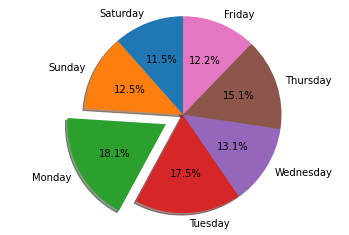

In [212]:
'''
#plotting bar - graph 'Number of Texts vs Weekdays'
plt.figure(figsize=(8,5))
plt.bar(range(len(weekday_count)), weekday_count.values(), align='center')
plt.xticks(range(len(weekday_count)), list(weekday_count.keys()))
plt.title('Weekdays texts count', fontsize=15)
plt.xlabel('Weekdays', fontsize=13)
plt.ylabel('Number of Texts', fontsize=13)
plt.show()
#individual graphs for all the members can also be plotted in the similar way
'''

#pie-chart
weekday_ids = {'Saturday': 0, 'Sunday': 1, 'Monday': 2, 'Tuesday': 3, 'Wednesday': 4, 'Thursday': 5, 'Friday': 6}
labels = weekday_count.keys()
sizes = weekday_count.values()

explode = [0, 0, 0, 0, 0, 0, 0]
explode[weekday_ids[maximum_day_whole]] = 0.2
explode = tuple(explode) #maximum_day pie is exploded

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

###Most active hour of the day

In [213]:
wa_data['Time'].value_counts()
time = wa_data['Time'].values

hour_list = []
hour_member = {}

#extracting the count of texts in a particular hour of the day, 24 hour format
for row in range(wa_data.shape[0]):
  hour = wa_data.iloc[row][1]
  hour_num = int(hour[0 : hour.find(':')])
  if 'PM' in hour:
    hour_num += 12
  name = wa_data.iloc[row][2]
  hour_member.setdefault(name, []).append(hour_num)
  hour_list.append(hour_num)

hour_count = Counter(hour_list)

#number of texts of whole conversation in an hour of the day
print('Texts in a hour:\n', dict(hour_count))

#number of texts of each member in an hour of the day
'''for name in hour_member.keys():
  print('\n' + name + "'s hourly texts count\n", dict(Counter(hour_member[name])))'''

#active and non-active hours of the whole conversion
maximum_hour_whole, maximum_count_whole, minimum_hour_whole, minimum_count_whole = max_min_dict(dict(hour_count))
print("\nThe whole conversation\n")
print('Hour of the day with maximum texts:', maximum_hour_whole, '| number of texts:', maximum_count_whole)
print('Hour of the day with minimum texts:', minimum_hour_whole, '| number of texts:', minimum_count_whole)

#active and non-active hours of all members
for name in hour_member.keys():
  print('\n' + name + "'s hourly texts\n")
  maximum_hour, maximum_count, minimum_hour, minimum_count = max_min_dict(dict(Counter(hour_member[name])))
  print('Hour of the day with maximum texts:', maximum_hour, '| number of texts:', maximum_count)
  print('Hour of the day with minimum texts:', minimum_hour, '| number of texts:', minimum_count)

Texts in a hour:
 {23: 3435, 12: 1090, 8: 491, 9: 2322, 10: 3340, 11: 3071, 24: 2680, 13: 1619, 14: 2343, 15: 2212, 17: 2513, 18: 2052, 19: 2956, 20: 1655, 21: 1825, 22: 3738, 16: 2224, 1: 182, 7: 207, 6: 8}

The whole conversation

Hour of the day with maximum texts: 22 | number of texts: 3738
Hour of the day with minimum texts: 6 | number of texts: 8

Member1's hourly texts

Hour of the day with maximum texts: 22 | number of texts: 1748
Hour of the day with minimum texts: 6 | number of texts: 3

Member2's hourly texts

Hour of the day with maximum texts: 10 | number of texts: 421
Hour of the day with minimum texts: 6 | number of texts: 2

Member3's hourly texts

Hour of the day with maximum texts: 23 | number of texts: 798
Hour of the day with minimum texts: 6 | number of texts: 1

Member4's hourly texts

Hour of the day with maximum texts: 23 | number of texts: 1056
Hour of the day with minimum texts: 6 | number of texts: 2


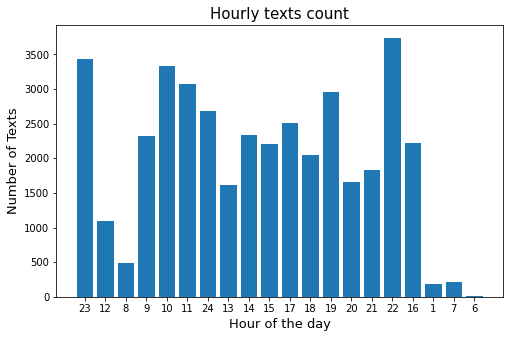

In [214]:
'''#pie-chart
labels = hour_count.keys()
sizes = hour_count.values()

explode = [i*0 for i in range(len(sizes))] #len(sizes) is used to make sure to create those hours of the day where conversations did happen
explode_target = list(labels).index(maximum_hour_whole)
explode[explode_target] = 0.2
explode = tuple(explode) #maximum_day pie is exploded

#fig1, ax1 = plt.subplots()
fig1, ax1 = plt.subplots(figsize=(7, 7))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.0f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()'''


#plotting graph 'Number of Texts vs Hour of the day'
plt.figure(figsize=(8, 5))
plt.bar(range(len(hour_count)), hour_count.values(), align='center')
plt.xticks(range(len(hour_count)), list(hour_count.keys()))
plt.title('Hourly texts count', fontsize=15)
plt.xlabel('Hour of the day', fontsize=13)
plt.ylabel('Number of Texts', fontsize=13)
plt.show()
#individual graphs for all the members can also be plotted in the similar way

###The Good Morning trend...

In [215]:
import demoji
demoji.download_codes()

... OK (Got response in 0.36 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK


In [216]:
wakeup_list = [0, 0, 0] #[hours, mins, count]
wakeup_member = {}

for row in range(wa_data.shape[0]):
  time = [0, 0, 0]
  text = wa_data.iloc[row][-1]
  text = text.strip()
  text = demoji.replace(text, '')
  text = text.lower()
  if 'good morning' in text:
    hour_mins = wa_data.iloc[row][1]
    sep = hour_mins.find(':')
    time[0], time[1] = int(hour_mins[0 : sep]), int(hour_mins[sep+1:sep+3])
    if 'PM' in hour_mins:
      time[0] += 12
    name = wa_data.iloc[row][2]
    wakeup_member.setdefault(name, [0, 0, 0]) 
    wakeup_member[name][0] += time[0] #hours
    wakeup_member[name][1] += time[1] #minutes   
    wakeup_member[name][2] += 1       #count
    wakeup_list[0] += time[0]
    wakeup_list[1] += time[1]    
    wakeup_list[2] += 1

print('Group average wake up time: ' + str(wakeup_list[0]//wakeup_list[2]) + ':' + str(wakeup_list[1]//wakeup_list[2]) + '\n')
for name in wakeup_member: 
  print(name + "'s average wake up time: " + str(wakeup_member[name][0]//wakeup_member[name][2]) + ':' + str(wakeup_member[name][1]//wakeup_member[name][2]) + '\n')

Group average wake up time: 8:31

Member2's average wake up time: 8:29

Member4's average wake up time: 8:30

Member3's average wake up time: 9:30

Member1's average wake up time: 8:34



###Word Frequncies

In [217]:
word_member = {}
word_list = []
neg_texts = []
ref_members = []
del_sentences = ['<Media omitted>', 'This message was deleted', 'You deleted this message']


for row in range(wa_data.shape[0]):
  message = wa_data.iloc[row][3]
  message = message.strip()
  message = demoji.replace(message, '')
  if message not in del_sentences and len(message) > 0:
    for word in message.split():
      if not regex.match('@[0-9]+', word):
        #for @mobilenumber when referred to, the regex checks for the string to start with '@' and followed numbers   
        name = wa_data.iloc[row][2]
        word = word.lower()
        word_member.setdefault(name, []).append(word)
        word_list.append(word)
      else:
        ref_members.append(word)

word_count = Counter(word_list)

#frequncy of words used in the whole conversation
#print('Words used in the whole conversation\n', dict(word_count))

#frequncy of words used by each member
'''for name in word_member.keys():
  print('\n' + name + "'s word frequency\n", dict(Counter(word_member[name])))'''

#Most and least used words of the whole conversion
maximum_word_whole, maximum_count_whole, _, _ = max_min_dict(dict(word_count))
print("\nThe whole conversation\n")
print('Most used word:', maximum_word_whole, '| number of times used:', maximum_count_whole, '| total words used(excluding media, deleted texts and references):', len(word_count))
#print('Least used word:', minimum_word_whole, '| number of times:', minimum_word_whole)

##Most and least used words of individual members
for name in word_member.keys():
  maximum_word, maximum_count, _, _ = max_min_dict(dict(Counter(word_member[name])))
  print('\n' + str(name) + "'s MOST used word: " + str(maximum_word) + ' (' + '{:.2f}'.format((maximum_count / len(word_member[name])) * 100) + "%)")


The whole conversation

Most used word: ha | number of times used: 986 | total words used(excluding media, deleted texts and references): 12293

Member1's MOST used word: ha (2.55%)

Member2's MOST used word: ok (1.95%)

Member3's MOST used word: ga (1.43%)

Member4's MOST used word: ha (1.85%)


In [218]:
import plotly.express as px

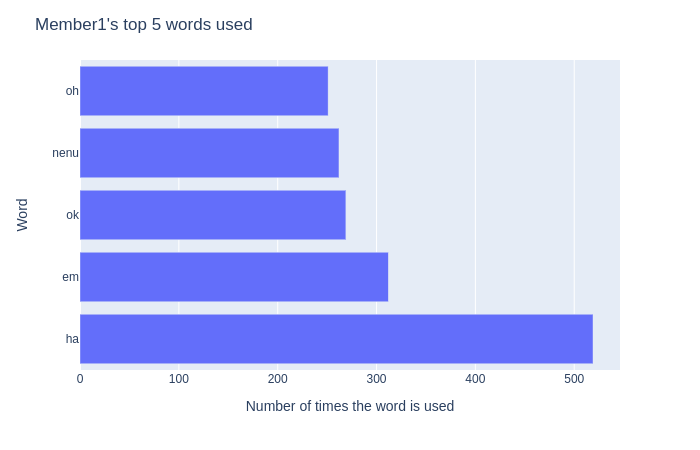

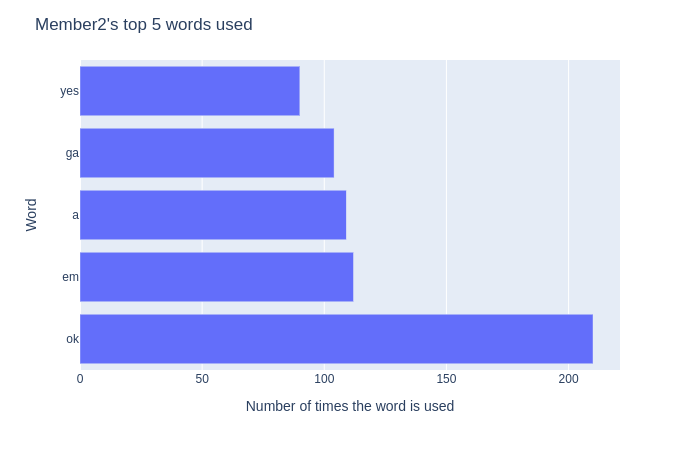

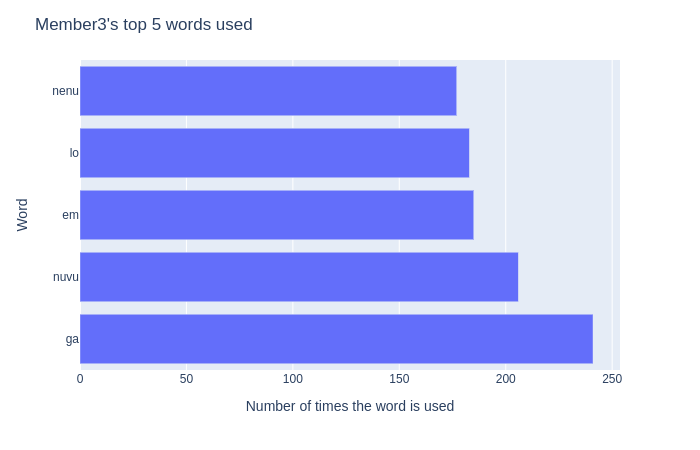

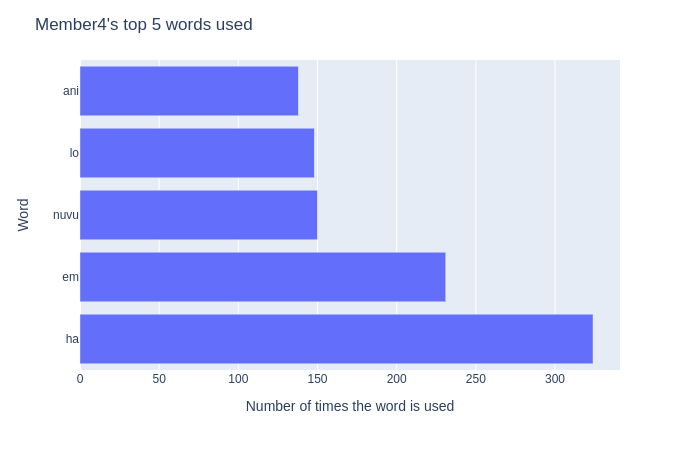

In [219]:
for name in word_member.keys():
  y = []
  x = []
  number_of_positions = 0
  name_count = Counter(word_member[name])
  for key, value in name_count.most_common():
    y.append(key)
    x.append(value)
    number_of_positions += 1
    if number_of_positions == 5: #top 5
      title = "{}'s top 5 words used".format(name)
      fig = px.bar(
            x = x,
            y = y,
            orientation='h')
      fig.update_layout(
      title = title,
      xaxis_title="Number of times the word is used",
      yaxis_title="Word")
      fig.show("png")
      break

####Generating custom WordCloud of the chat
######Source: https://www.datacamp.com/community/tutorials/wordcloud-python

In [220]:
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

In [221]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

final_text = ''
final_text += " ".join(word_list) + " "

#image to be used for the mask
mask = np.array(Image.open("whatsapp_logo.png"))

#if the mask image is 3 channel image
if len(mask.shape) == 3:  
  mask = mask[:,:,0]

transformed_mask = np.ndarray((mask.shape[0],mask.shape[1]), np.int32)

for i in range(len(mask)):
    transformed_mask[i] = list(map(transform_format, mask[i]))
'''
wc = WordCloud(background_color="white", max_words=1000, mask=transformed_wine_mask,
               stopwords= STOPWORDS, contour_width=3, contour_color='firebrick')'''

wc = WordCloud(background_color = "white", max_words = 3000, mask = transformed_mask,
               stopwords= STOPWORDS)

# Generate a wordcloud
wc.generate(final_text)

# the wordcloud generated is saved as file 
wc.to_file("word_cloud.png")

#neglected texts
#print(set(neg_texts))

###Well, emojies are a good way to end!

In [222]:
from emoji import UNICODE_EMOJI

emoji_list = []
emoji_member = {}

for row in range(wa_data.shape[0]):
  message = wa_data.iloc[row][-1]
  message = message.strip()
  if message not in del_sentences and len(message) > 0:
    for char in message:
      if char in UNICODE_EMOJI:
        name = wa_data.iloc[row][2]
        emoji_member.setdefault(name, []).append(char)
        emoji_list.append(char)

emoji_count = Counter(emoji_list)

#emoji frequency of the whole conversation
#print('Emojies\n', dict(emoji_count))

#number of each type of emoji used by a member
'''for name in emoji_member.keys():
  print('\n' + name + "'s emoji count\n", dict(Counter(emoji_member[name])))'''

#Most and least used emojies of the whole conversion
maximum_emoji_whole, maximum_count_whole, _, _ = max_min_dict(dict(emoji_count))
print("\nThe whole conversation\n")
print('Most used emoji:', maximum_emoji_whole, '| number of times used:', maximum_count_whole, '| total emojies used:', len(emoji_list))
#print('Least used emoji:', minimum_emoji_whole, '| number of times used:', minimum_count_whole)

#most and least emojies used by members
for name in emoji_member.keys():
  maximum_emoji, maximum_count, _, _ = max_min_dict(dict(Counter(emoji_member[name])))
  print('\n' + str(name) + "'s MOST used emoji: " + str(maximum_emoji) + ' (' + '{:.2f}'.format((maximum_count / len(emoji_member[name])) * 100) + "%)")


The whole conversation

Most used emoji: 😂 | number of times used: 9666 | total emojies used: 31067

Member1's MOST used emoji: 😂 (31.53%)

Member3's MOST used emoji: 🤣 (25.01%)

Member4's MOST used emoji: 😂 (32.53%)

Member2's MOST used emoji: 😂 (34.84%)


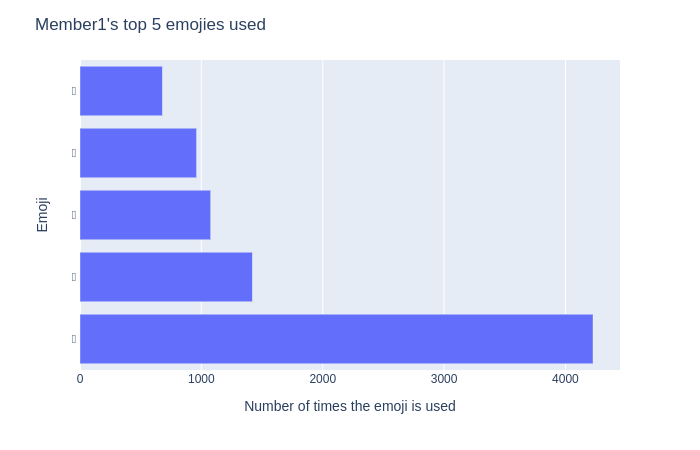

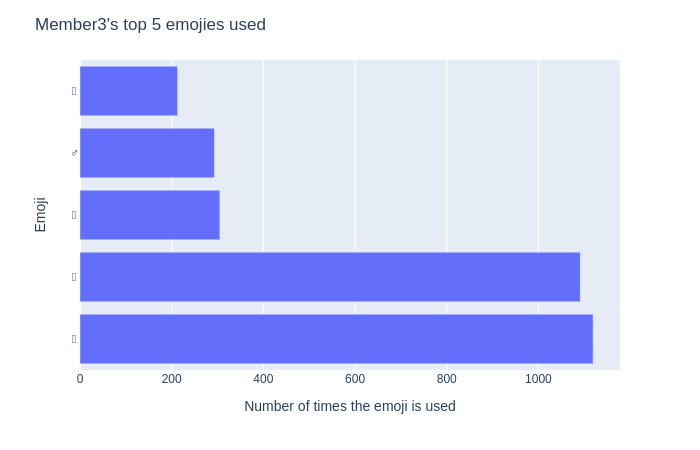

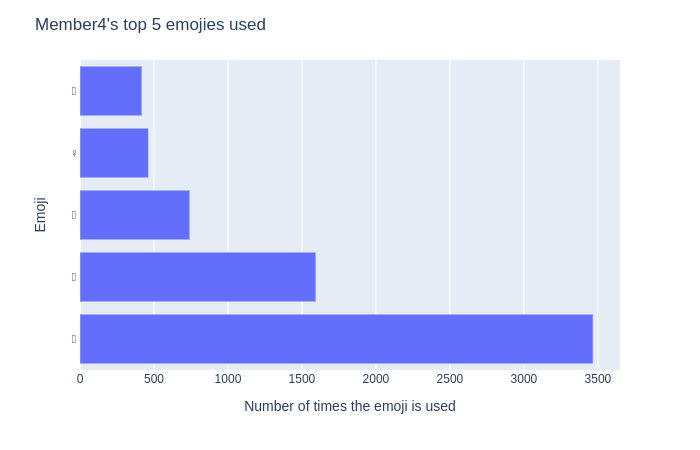

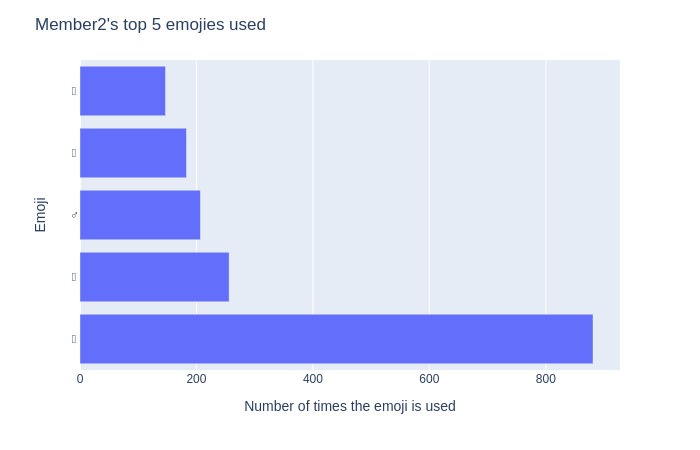

In [223]:
for name in emoji_member.keys():
  y = []
  x = []
  number_of_positions = 0
  name_count = Counter(emoji_member[name])
  for key, value in name_count.most_common():
    y.append(key)
    x.append(value)
    number_of_positions += 1
    if number_of_positions == 5: #top 5
      title = "{}'s top 5 emojies used".format(name)
      fig = px.bar(
            x = x,
            y = y,
            orientation='h')
      fig.update_layout(
      title = title,
      xaxis_title="Number of times the emoji is used",
      yaxis_title="Emoji")
      fig.show("png")
      break

###Many plotting libraries are available to express the stats in a great and interactive way.
https://www.analyticsvidhya.com/blog/2020/03/6-data-visualization-python-libraries/

Make sure to check out the article for very exicting plotting possibilities.

The issue of displaying plotly plots on github is solved by referring to,
 
*   https://plotly.com/python/static-image-export/
*   https://github.com/nicolaskruchten/plotly_img_test/blob/master/Untitled.ipynb

